<a href="https://colab.research.google.com/github/kuds/rl-mujoco-tennis/blob/main/%5BMuJoCo%20Humanoid%5D%20Proximal%20Policy%20Optimization%20(PPO).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mujoco

In [2]:
!pip install stable-baselines3

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 473, in run
    env = get_environment(lib_locations)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/metadata/__init__.py", line 86, in get_environment
    return select_backend().Environment.from_paths(paths)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/metadata/pkg_resources.py", line 263, in from_paths
    return cls(pkg_resources.WorkingSet(paths))
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 584, in __init__
    self.add_entry(entry)
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_reso

In [3]:
!pip install mujoco

# Set up GPU rendering.
from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

In [4]:
import gymnasium
import mujoco
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import VecVideoRecorder
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
import numpy
import os
import torch
import platform
from importlib.metadata import version
import matplotlib
import matplotlib.pyplot

In [5]:
print(f"Python Version: {platform.python_version()}")
print(f"Torch Version: {version('torch')}")
print(f"Is Cuda Available: {torch.cuda.is_available()}")
print(f"Cuda Version: {torch.version.cuda}")
print(f"Gymnasium Version: {version('gymnasium')}")
print(f"Numpy Version: {version('numpy')}")
print(f"Tensorflow Version: {version('tensorflow')}")
print(f"tqdm Version: {version('tqdm')}")
print(f"MuJoCo Version: {version('mujoco')}")
print(f"Stable Baselines3 Version: {version('stable_baselines3')}")

Python Version: 3.10.12
Torch Version: 2.5.1+cu121
Is Cuda Available: True
Cuda Version: 12.1
Gymnasium Version: 0.29.1
Numpy Version: 1.26.4
Tensorflow Version: 2.17.1
tqdm Version: 4.66.6
MuJoCo Version: 3.2.5
Stable Baselines3 Version: 2.3.2


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
rl_type = "PPO"
env_str = "Humanoid-v4"
log_dir = "./logs/{}".format(env_str)
name_prefix = "humanoid"

In [ ]:
# Create the Humanoid environment
env = make_vec_env(env_str, n_envs=4)

# Create the PPO model
model = PPO(
    policy="MlpPolicy",  # Multi-layer perceptron policy
    env=env,
    verbose=0,
    learning_rate=0.0003,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.0
)

eval_callback = EvalCallback(env,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             eval_freq=25_000)

# Train the model
time_steps = 1_000_000
model.learn(total_timesteps=time_steps, callback=eval_callback)

# Save the model
model.save(os.path.join(log_dir, "ppo_humanoid"))

mean_reward, std_reward = evaluate_policy(model, env)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

In [8]:
# Create Evaluation CarRacing environment
env = make_vec_env(env_str, n_envs=1, seed=0)

# Load the best model
best_model_path = os.path.join(log_dir, "best_model.zip")
best_model = PPO.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model playing CarRacing
env = VecVideoRecorder(env, "./videos/",
                       video_length=10_000,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix="best_model_{}".format(name_prefix))

obs = env.reset()
for _ in range(10_000):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
        break

env.close()

Best Model - Mean reward: 370.70 +/- 24.16


/usr/local/lib/python3.10/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


Moviepy - Building video /content/videos/best_model_car_racing_ppo-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/videos/best_model_car_racing_ppo-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/best_model_car_racing_ppo-step-0-to-step-10000.mp4


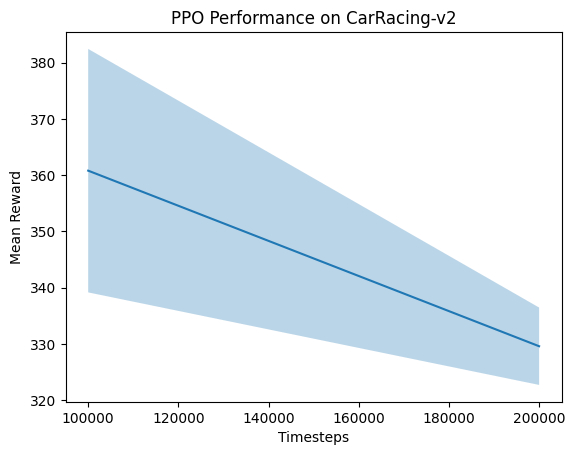

In [7]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title('PPO Performance on CarRacing-v2')
matplotlib.pyplot.show()